In [50]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from oggm import utils

In [46]:
rgi_df = []
for reg in range(1, 20):
    df = gpd.read_file(utils.get_rgi_region_file(f'{reg:02d}', version='62'))
    # For greenland we omit connectivity level 2
    if f'{reg:02d}' == '05':
        df = df.loc[df['Connect'] != 2]
    rgi_df.append(df)
rgi_df = pd.concat(rgi_df)

In [59]:
rgi_df = rgi_df.set_index('RGIId')

In [48]:
df_exp = pd.read_csv('hypercube_oggm_v1.csv', index_col=0)
df_exp

melt_f  temp_bias  prcp_fac  temp_melt    glen_a
exp                                                    
0         NaN        NaN       NaN        NaN       NaN
1    0.929854   4.207692  0.500106   2.465717  1.227012
2   -1.419858   2.968814  1.018419   2.566880  0.301513
3   -0.494130   1.832253  1.317409  -2.679599  3.253977
4   -0.867532   0.217129  1.502506   1.465335  3.844472
..        ...        ...       ...        ...       ...
56  -1.962294   3.350424  0.581279   0.108113  0.244264
57   1.687135   3.961539  1.848938  -0.643535  2.751957
58   0.575291  -4.367014  0.904198  -0.974160  1.476149
59   1.353723  -1.489551  0.746143  -0.508018  0.890884
60   1.648370  -2.589388  1.793763   1.878010  0.376560

[61 rows x 5 columns]

In [109]:
gcms = ['IPSL-CM6A-LR', 'MRI-ESM2-0']
ssps = ['ssp126', 'ssp585']


for rgi_reg in range(1, 20):
    rgi_reg = f'{rgi_reg:02d}'

    diro = f'output_agg/RGI{rgi_reg}/'
    utils.mkdir(diro, reset=True)

    df_exp_copy = df_exp.copy()

    for gcm in gcms:
        for ssp in ssps:

            df_vol = pd.DataFrame()
            df_vol_bsl = pd.DataFrame()
            df_slr = pd.DataFrame()
            df_err = pd.DataFrame()

            for exp in range(61):

                vfiles = sorted(glob.glob(f'output/RGI{rgi_reg}/{gcm}/{gcm}_{ssp}_exp_{exp:02d}_batch_*.csv'))
                errfiles = sorted(glob.glob(f'output/RGI{rgi_reg}/{gcm}/{gcm}_{ssp}_exp_{exp:02d}_failed_ids_batch_*.json'))

                assert len(vfiles) == len(errfiles)
                assert len(vfiles) > 0

                df = 0
                err_l = []
                for fv, fe in zip(vfiles, errfiles):
                    with open(fe, 'r') as f:
                        err_exp = np.array(json.load(f)[f'{exp:02d}']).flatten()
                        err_l = np.append(err_l, err_exp)
                    df += pd.read_csv(fv, index_col=0)
                    
                valid_perc = 1 - rgi_df.loc[err_l].Area.sum() / rgi_df.loc[rgi_df.O1Region == str(int(rgi_reg))].Area.sum()
                df_err.loc[f'{exp:02d}', 'valid'] = valid_perc    

                df_vol[f'{exp:02d}'] = df.volume * 1e-9
                df_vol_bsl[f'{exp:02d}'] = df.volume_bsl * 1e-9

                df_exp_copy.loc[int(exp), f'valid_{gcm}_{ssp}'] = valid_perc

            # Correct default exp
            df_vol['00'] = df_vol['00'] / df_err.loc['00', 'valid']

            # Correct all other expts
            for exp in range(1, 61):
                df_vol[f'{exp:02d}'] = df_vol[f'{exp:02d}'] * df_vol.loc[2000, '00'] / df_vol.loc[2000, f'{exp:02d}']

            # SLR
            rho = 900
            rho_w = 1000
            A_oc = 362.5 * 1e9
            df_slr = (df_vol * 1e9 * (rho / rho_w) - df_vol_bsl * 1e9) / A_oc
            df_slr = df_slr.iloc[0] - df_slr

            df_slr.to_csv(diro + f'slr_{gcm}_{ssp}.csv')
            df_vol.to_csv(diro + f'vol_{gcm}_{ssp}.csv')

    df_exp_copy.to_csv(diro + f'hypercube_valid.csv')

In [110]:
# ! less output/RGI13/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp585_exp_27_batch_119.csv

In [92]:
# diro = f'output_agg/global/'
# utils.mkdir(diro, reset=True)

# for gcm in gcms:
#     for ssp in ssps:
#         for rgi_reg in range(1, 20):
#             rgi_reg = f'{rgi_reg:02d}'
#             diri = f'output_agg/RGI{rgi_reg}/'
#             hyper_reg = pd.read_csv(diro + f'hypercube_valid_{gcm}_{ssp}.csv', index_col=0)

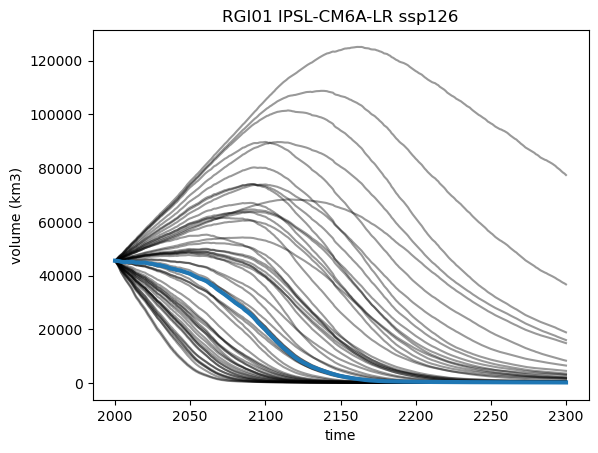

In [107]:
df_vol.plot(legend=False, color='k', alpha=0.4);
df_vol['00'].plot(c='C0', linewidth=3);
plt.title('RGI01 IPSL-CM6A-LR ssp126');
plt.ylabel('volume (km3)');

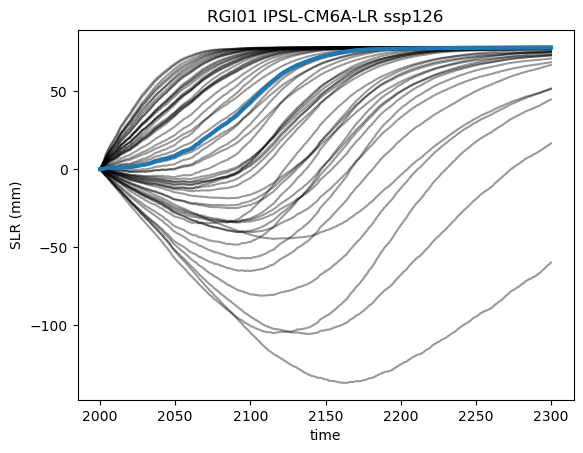

In [108]:
df_slr.plot(legend=False, color='k', alpha=0.4);
df_slr['00'].plot(c='C0', linewidth=3);
plt.title('RGI01 IPSL-CM6A-LR ssp126');
plt.ylabel('SLR (mm)');

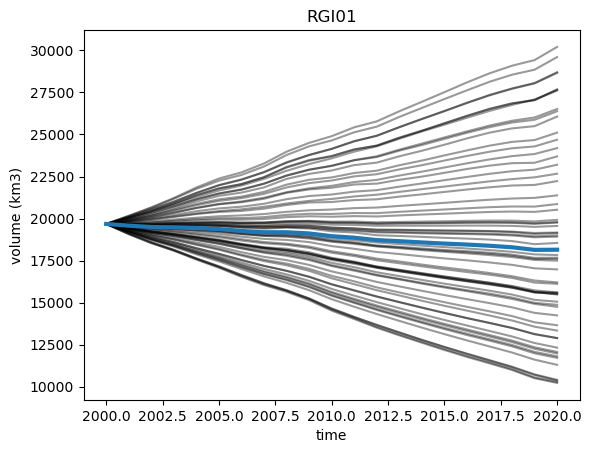

In [94]:
df_vol.loc[:2020].plot(legend=False, color='k', alpha=0.4);
df_vol.loc[:2020]['00'].plot(c='C0', linewidth=3);

plt.title('RGI01');
plt.ylabel('volume (km3)');

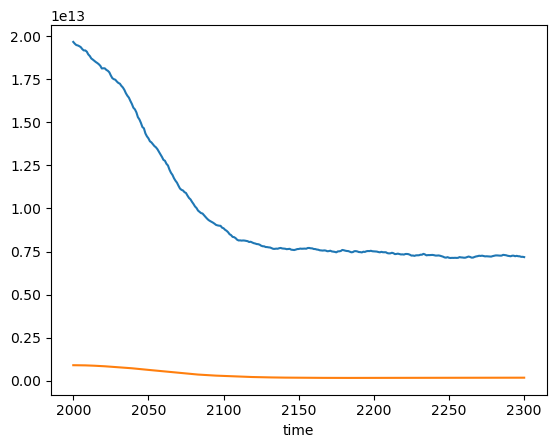

In [21]:
df.volume.plot();
df.volume_bsl.plot();

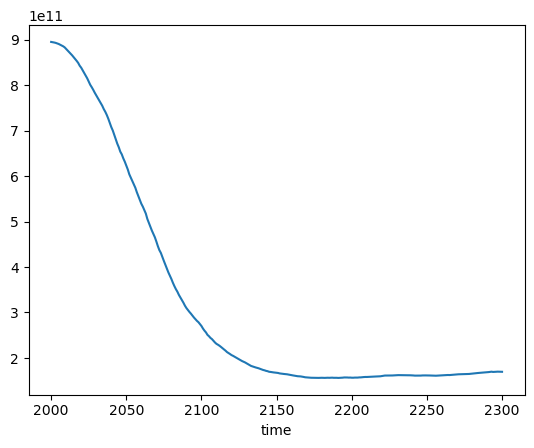

In [18]:
f'output/RGI01/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp126_{exp:02d}_00_batch_*.csv'

'output/RGI01/IPSL-CM6A-LR/IPSL-CM6A-LR_ssp126_00_00_batch_*.csv'